In [1]:
using CollectiveSpins
using QuantumOptics
using PyPlot
using LinearAlgebra
using JLD2
using Statistics

In [2]:
""" Compute the atomic energy in a harmonic centered trap for each atom """
function compute_OmegatAt_HT(Nx, Ny, Nz, ω0lat, d_xy, d_z)
    ω0lat_array = zeros(N)
    Matidx = reshape([1:N;], Nx, Ny, Nz)
    for i=1:N
        idx = findall(x->x==i, Matidx)[1]
        x, y, z = idx[1], idx[2], idx[3]
        # Compute the normalised distance from the center of the trap
        d = sqrt((x-1 - (Nx-1)/2)^2 + (y-1 - (Ny-1)/2)^2 + (z-1 - (Nz-1)/2)^2)
        ω0lat_array[i] = ω0lat * d^2
    end
    return ω0lat_array
end

compute_OmegatAt_HT

In [3]:
# Define geometry of system
Nx,Ny,Nz = [5,5,1]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis
Γ0 = 1. # In Hz

theta_init = pi/2
phi_init = 1

θl = 30*pi/180 # Angle of the laser
λ = 1299.

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

Ω_ZZ_coeff = [53, 42, 33]./Γ0

# Lattice frequency
ω0lat = 3e-1 # Normalised by Γ0

ω0lat_array = compute_OmegatAt_HT(Nx, Ny, Nz, ω0lat, d_xy, d_z)

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

### QC C functions with HT

In [4]:
@load "Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2))" sol;

In [5]:
mean_σx_QC_HT = [2*mean(real(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σy_QC_HT = [2*mean(imag(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σz_QC_HT = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
mean_σz67_QC_HT = -1 .*(mean_σz_QC_HT.+1) ./2 .- 6

σz_QC_HT = [2 .*real(sol[i][1:N]).-1 for i=1:length(T)];

### QC C functions without HT

In [6]:
@load "Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_thetal_$(round(θl, digits=2))" sol;

In [7]:
mean_σx_QC_no_HT = [2*mean(real(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σy_QC_no_HT = [2*mean(imag(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σz_QC_no_HT = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
mean_σz67_QC_no_HT = -1 .*(mean_σz_QC_no_HT.+1) ./2 .- 6

σz_QC_no_HT = [2 .*real(sol[i][1:N]).-1 for i=1:length(T)];

# Plots

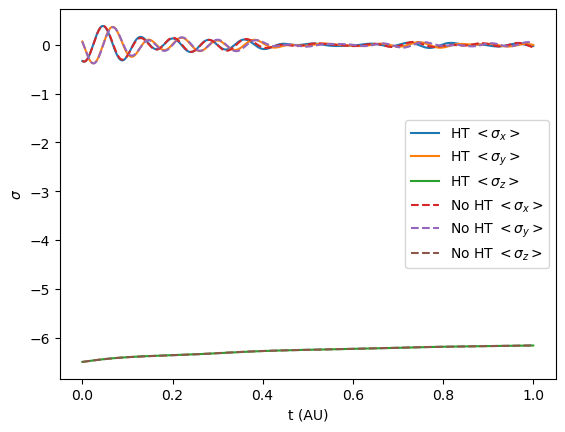

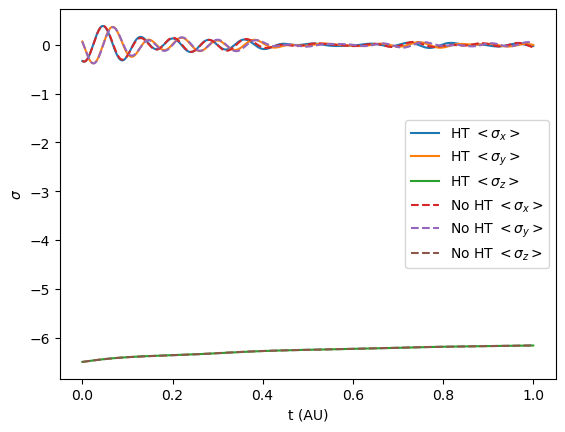

In [8]:
close("all")
figure()

plot(T, mean_σx_QC_HT, label=L"HT $<\sigma_x>$", linestyle="-")
plot(T, mean_σy_QC_HT, label=L"HT $<\sigma_y>$", linestyle="-")
plot(T, mean_σz67_QC_HT, label=L"HT $<\sigma_z>$", linestyle="-")
plot(T, mean_σx_QC_no_HT, label=L"No HT $<\sigma_x>$", linestyle="--")
plot(T, mean_σy_QC_no_HT, label=L"No HT $<\sigma_y>$", linestyle="--")
plot(T, mean_σz67_QC_no_HT, label=L"No HT $<\sigma_z>$", linestyle="--")

xlabel("t (AU)")
ylabel(L"\sigma")
legend()

#pygui(true); show()
pygui(false); gcf()

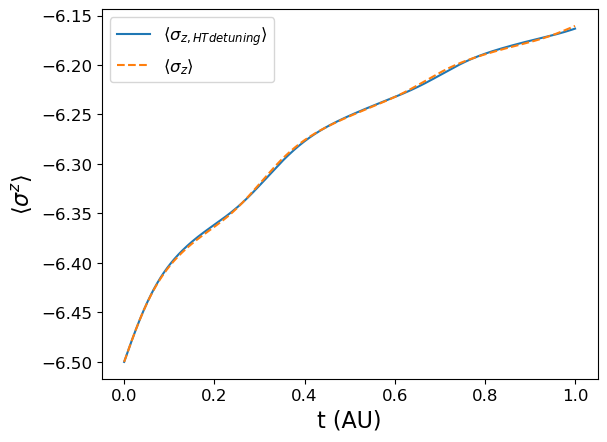

In [9]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, mean_σz67_QC_HT, label=L"$\langle\sigma_{z, HT detuning}\rangle$", linestyle="-")
plot(T, mean_σz67_QC_no_HT, label=L"$\langle\sigma_{z}\rangle$", linestyle="--")

xlabel("t (AU)", fontsize=16)
ylabel(L"$\langle\sigma^z\rangle$", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HTdetuningSigmaz_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

#pygui(true); show()
pygui(false); #gcf()

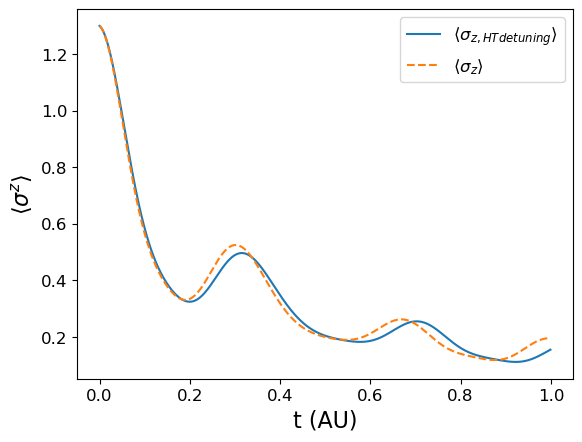

In [ ]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T[1:end-1], diff(mean_σz67_QC_HT)./Tstep, label=L"$\langle\sigma_{z, HT detuning}\rangle$", linestyle="-")
plot(T[1:end-1], diff(mean_σz67_QC_no_HT)./Tstep, label=L"$\langle\sigma_{z}\rangle$", linestyle="--")

xlabel("t (AU)", fontsize=16)
ylabel(L"\partial_t\langle\sigma^z\rangle", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HTdetuningDiffSigmaz_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")

#pygui(true); show()
pygui(false); #gcf()

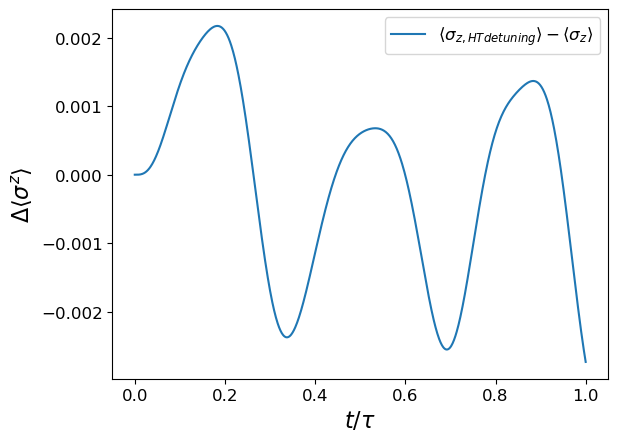

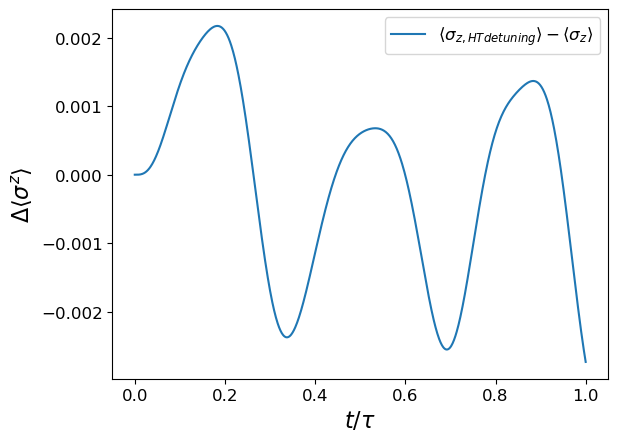

In [11]:
close("all")
figure()

PyPlot.rc("font", size = 12)

plot(T, mean_σz67_QC_HT-mean_σz67_QC_no_HT, label=L"$\langle\sigma_{z, HT detuning}\rangle - \langle\sigma_{z}\rangle$", linestyle="-")

xlabel(L"t/\tau", fontsize=16)
ylabel(L"$\Delta\langle\sigma^z\rangle$", fontsize=16)
legend()

#savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HTdetuningDiff_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")


#pygui(true); show()
pygui(false); gcf()

1
6
11
16
21


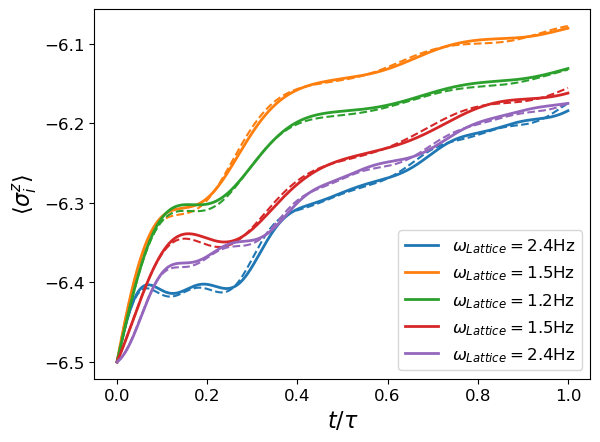

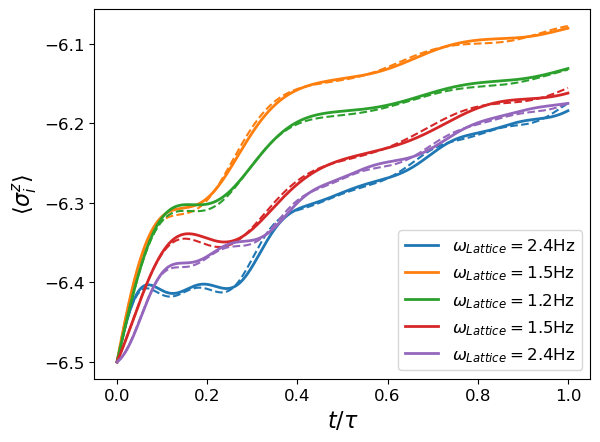

In [18]:
close("all")
figure()

for i = 1:5:N
    println(i)
    if i >11
        plt = plot(T, [-1 *(σz_QC_HT[t][i]+1) /2 - 6 for t = 1:length(T)], label=L"\omega_{Lattice} = "*string(round(ω0lat_array[i], digits=2))*"Hz", linestyle="-", linewidth = 2)
    else
        plt = plot(T, [-1 *(σz_QC_HT[t][i]+1) /2 - 6 for t = 1:length(T)], label=L"\omega_{Lattice} = "*string(round(ω0lat_array[i], digits=2))*"Hz", linestyle="-", linewidth = 2)
    end

    plot(T, [-1 *(σz_QC_no_HT[t][i]+1) /2 - 6 for t = 1:length(T)], linestyle="--", color=plt[1].get_color())
end

xlabel(L"t/\tau", fontsize=16)
ylabel(L"\langle\sigma_i^z\rangle", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HTDetuning_Sigmazi_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")


#pygui(true); show()
pygui(false); gcf()

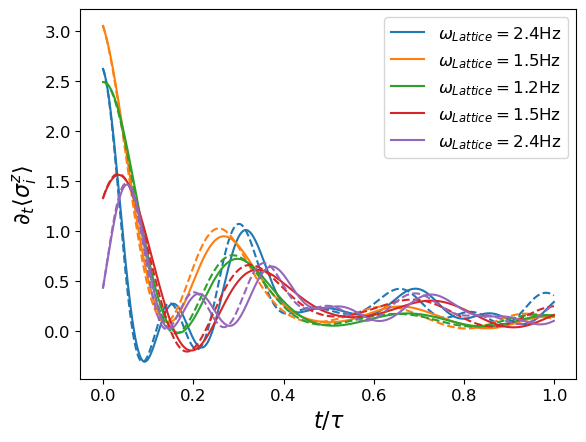

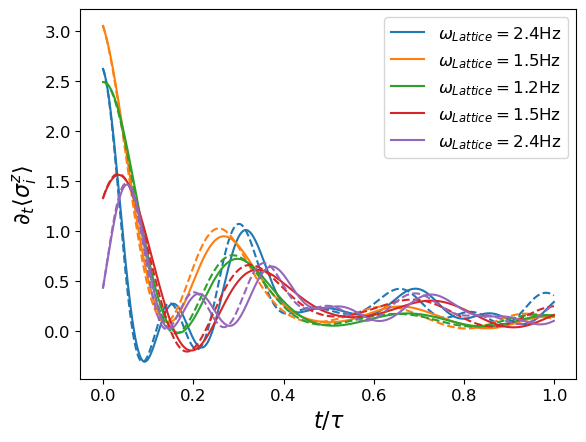

In [13]:
close("all")
figure()

for i = 1:5:N
    plt = plot(T[1:end-1], diff([-1 *(σz_QC_HT[t][i]+1) /2 - 6 for t = 1:length(T)])./Tstep, label=L"\omega_{Lattice} = "*string(round(ω0lat_array[i], digits=2))*"Hz", linestyle="-")
    plot(T[1:end-1], diff([-1 *(σz_QC_no_HT[t][i]+1) /2 - 6 for t = 1:length(T)])./Tstep, linestyle="--", color=plt[1].get_color())
end

xlabel(L"t/\tau", fontsize=16)
ylabel(L"\partial_t\langle\sigma_i^z\rangle", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HTDetuning_DiffSigmazi_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")


#pygui(true); show()
pygui(false); gcf()

In [14]:
"HTDetuning_DiffSigmazi_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2)).pdf"

"HTDetuning_DiffSigmazi_5_Ny_5_Nz_1_theta_1.6_phi_1_HT_0.3_thetal_0.52.pdf"

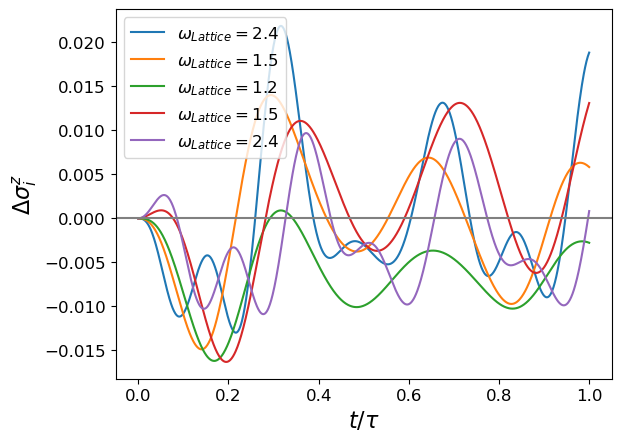

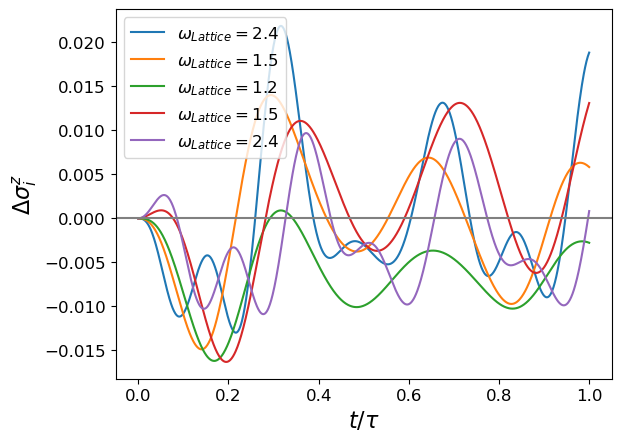

In [15]:
close("all")
figure()

for i = 1:5:N
    plot(T, [σz_QC_HT[t][i]-σz_QC_no_HT[t][i] for t = 1:length(T)], label=L"\omega_{Lattice} = "*string(round(ω0lat_array[i], digits=2)), linestyle="-")
end

xlabel(L"t/\tau", fontsize=16)
ylabel(L"\Delta\sigma_i^z", fontsize=16)
legend()

axhline(0, color = "gray")

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HTDetuning_DiffSigmazi_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)_thetal_$(round(θl, digits=2)).pdf", bbox_inches="tight")


#pygui(true); show()
pygui(false); gcf()

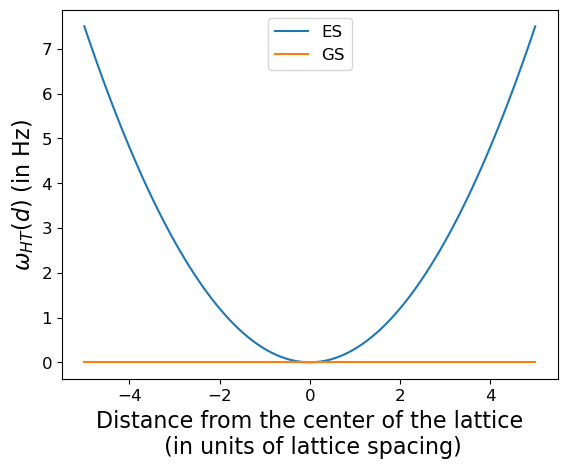

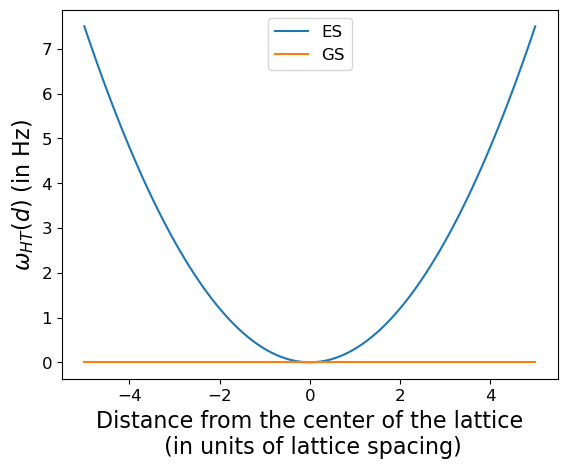

In [16]:
close("all")
figure()

x = range(-5, 5, 100)
E = ω0lat .* x .^2
plot(x, E, label="ES")
plot(x, zeros(length(x)), label="GS")



xlabel("Distance from the center of the lattice\n (in units of lattice spacing)", fontsize=16)
ylabel(L"$\omega_{HT}(d)$ (in Hz)", fontsize=16)
legend()

savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/HTdetuningEnergyLevels.pdf", bbox_inches="tight")


gcf()